In [95]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import roc_curve, auc

import torch

from autoencoder import AutoEncoder, loss
from main import main, parse_args

In [148]:
####################################### GPU or CPU running ###########################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#######################################################################################################
####################################### Data Initialization ###########################################

path, scale, mid_dim, latent_dim = 'local', 'minmax', 84, 14

if path == "local":
    path = "../GAN-AE/clustering-lhco/data"
elif path == "server": 
    path = "/AtlasDisk/user/duquebran/clustering-lhco/data"

bkg = pd.read_hdf(f"{path}/RnD_2j_scalars_bkg.h5")
sig1 = pd.read_hdf(f"{path}/RnD_2j_scalars_sig.h5")
sig2 = pd.read_hdf(f"{path}/RnD2_2j_scalars_sig.h5")

selection = pd.read_csv("dijet-selection.csv", header=None).values[:, 0]
smooth_cols = pd.read_csv("../Autoencoder/scale-selection.csv", header=None).values[:, 0]

bkg.replace([np.nan, -np.inf, np.inf], 0, inplace=True)
sig1.replace([np.nan, -np.inf, np.inf], 0, inplace=True)
sig2.replace([np.nan, -np.inf, np.inf], 0, inplace=True)

mass = 'mj1j2'
scope = [2700, 5000]

bkg = bkg[(bkg[mass] > scope[0]) & (bkg[mass] < scope[1])].reset_index()
sig1 = sig1[(sig1[mass] > scope[0]) & (sig1[mass] < scope[1])].reset_index()
sig2 = sig2[(sig2[mass] > scope[0]) & (sig2[mass] < scope[1])].reset_index()

mjj_bkg = bkg[mass].values
mjj_sig1 = sig1[mass].values
mjj_sig2 = sig2[mass].values

#######################################################################################################
############################################# Reweighting #############################################

Hc,Hb = np.histogram(mjj_bkg,bins=500)
weights = np.array(Hc,dtype=float)
weights[weights > 0.0] = 1.0 / weights[weights > 0.0]
weights[weights == 0.0] = 1.0
weights = np.append(weights, weights[-1])
weights *= 1000.0 # To avoid very small weights
weights_bkg = weights[np.searchsorted(Hb, mjj_bkg)]
weights_sig1 = weights[np.searchsorted(Hb, mjj_sig1)]
weights_sig2 = weights[np.searchsorted(Hb, mjj_sig2)]



Using device: cpu


In [181]:
#######################################################################################################
######################################## Data Preprocessing ###########################################

if scale == "minmax":
    scaler = MinMaxScaler()
elif scale == "standard":
    scaler = StandardScaler()

sample_bkg = bkg[selection].sample(frac=1)
sample_sig1 = sig1[selection].sample(frac=1)
sample_sig2 = sig2[selection].sample(frac=1)

# Concatenate all datasets for the current column to find the global min and max
all_data = pd.concat([sample_bkg, sample_sig1, sample_sig2])

for col in smooth_cols:
    first_positive = all_data[col][all_data[col] > 0].min()
    print(f"Min {col}: {first_positive}")
    all_data[col] = np.where(all_data[col] <= 0, first_positive, all_data[col])

# all_data[smooth_cols] = all_data[smooth_cols].apply(lambda x: np.log(x))


# # Create a MinMaxScaler object with adjusted parameters for the current column
# scaler = MinMaxScaler()
# data_scaled = pd.DataFrame(scaler.fit_transform(all_data), columns=selection)

# # Apply scaling to each dataset per column
# bkg_scaled = data_scaled.iloc[:len(sample_bkg)]
# sig1_scaled = data_scaled.iloc[len(sample_bkg):-len(sample_sig2)]
# sig2_scaled = data_scaled.iloc[-len(sample_sig2):]

Min pt_1: 1200.0002534724663
Min mass_1: 1.52587890625e-05
Min pt_2: 473.29961065138576
Min mass_2: 1.52587890625e-05
Min tau1_1: 5.5162080411259545e-05
Min tau2_1: 0.00018048323435083355
Min tau3_1: 2.915105775273945e-05
Min tau1_2: 0.00021311324723332156
Min tau2_2: 0.0001037333225844891
Min tau3_2: 4.589669322889097e-05
Min eRing0_1: 0.0001459535282614222
Min eRing1_1: 0.00013106157357569808
Min eRing2_1: 0.00010654640769938819
Min eRing3_1: 9.28627819986825e-05
Min eRing4_1: 0.00010778852272743369
Min eRing5_1: 7.994737072551168e-05
Min eRing6_1: 5.1155246288379536e-05
Min eRing7_1: 6.868989023650655e-05
Min eRing8_1: 5.217741704209237e-05
Min eRing9_1: 3.488946364402841e-05
Min eRing0_2: 0.00010064332049283848
Min eRing1_2: 0.00014315195318922758
Min eRing2_2: 8.067553761867104e-05
Min eRing3_2: 0.000128500387959262
Min eRing4_2: 0.00012757953438705534
Min eRing5_2: 7.89674411137589e-05
Min eRing6_2: 8.560868582793932e-05
Min eRing7_2: 7.257467310019255e-05
Min eRing8_2: 3.3264893

In [185]:
(all_data[smooth_cols] <= 0).any().to_numpy()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [150]:
print(len(sample_bkg))
print(len(sample_sig1))
print(len(sample_sig2))

656455
93383
94047


In [156]:
sig2_scaled

,pt_1,eta_1,e_1,mass_1,nisj_1,nesj_1,tau1_1,tau2_1,tau3_1,tau32_1,...,eRing0_2,eRing1_2,eRing2_2,eRing3_2,eRing4_2,eRing5_2,eRing6_2,eRing7_2,eRing8_2,eRing9_2
0,0.393411,0.635009,0.255114,0.082780,0.034483,0.216080,0.568837,0.486098,0.544787,0.138601,...,0.349200,0.326998,0.000000,0.478431,0.411712,0.649075,0.931673,0.830922,0.557021,0.875966
1,0.212374,0.519377,0.093275,0.085946,0.000000,0.165829,0.613512,0.521587,0.563771,0.121093,...,0.000000,0.000000,0.000000,0.556801,0.810931,0.930859,0.809756,0.398129,0.360806,0.811853
2,0.255371,0.458308,0.130752,0.385439,0.241379,0.286432,0.824185,0.631135,0.609026,0.067920,...,0.856980,0.717685,0.536057,0.615731,0.893995,0.771003,0.739212,0.529991,0.513426,0.000000
3,0.080351,0.446947,0.040989,0.080500,0.034483,0.140704,0.602964,0.531801,0.563723,0.108966,...,0.000000,0.000000,0.000000,0.000000,0.380790,0.466846,0.535720,0.851695,0.967604,0.602766
4,0.209666,0.448019,0.096648,0.087982,0.000000,0.150754,0.611833,0.535744,0.570814,0.114009,...,0.000000,0.000000,0.363139,0.000000,0.317051,0.571521,0.891816,0.892000,0.867164,0.501083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94042,0.025488,0.256379,0.177669,0.086794,0.103448,0.190955,0.630285,0.475599,0.538846,0.143683,...,0.000000,0.000000,0.000000,0.000000,0.253158,0.596540,0.955588,0.866757,0.575920,0.429429
94043,0.260831,0.286933,0.276994,0.069943,0.000000,0.130653,0.592581,0.496529,0.506761,0.078612,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.488440,0.816089,0.944991,0.851542,0.524918
94044,0.194021,0.206165,0.400149,0.083783,0.068966,0.165829,0.577251,0.479478,0.515981,0.104714,...,0.000000,0.000000,0.000000,0.753993,0.866767,0.652996,0.812802,0.677002,0.859902,0.800216
94045,0.246376,0.611444,0.157032,0.079304,0.000000,0.236181,0.585194,0.499670,0.565240,0.154394,...,0.000000,0.000000,0.000000,0.352120,0.303272,0.473114,0.533660,0.947329,0.903675,0.000000


In [153]:
all_data.iloc[-len(sample_sig2):]

,pt_1,eta_1,e_1,mass_1,nisj_1,nesj_1,tau1_1,tau2_1,tau3_1,tau32_1,...,eRing0_2,eRing1_2,eRing2_2,eRing3_2,eRing4_2,eRing5_2,eRing6_2,eRing7_2,eRing8_2,eRing9_2
70788,1919.541195,0.617984,2300.631976,112.158176,2,44,0.041113,0.026637,0.021188,0.795451,...,0.002504,0.002583,0.000000,0.009333,0.005116,0.036213,0.526203,0.199595,0.010380,0.208073
85068,1588.427812,0.115705,1603.306698,116.446882,1,34,0.069114,0.038356,0.026656,0.694972,...,0.000000,0.000000,0.000000,0.018832,0.183403,0.517930,0.168027,0.003226,0.001373,0.107209
79329,1667.069534,-0.149562,1764.786642,522.226203,8,58,0.800493,0.118210,0.046079,0.389802,...,0.268113,0.081861,0.012612,0.031925,0.386229,0.114502,0.086799,0.011338,0.006622,0.000000
59194,1346.961329,-0.198913,1378.019614,109.068609,2,29,0.061137,0.042600,0.026641,0.625373,...,0.000000,0.000000,0.000000,0.000000,0.003877,0.006481,0.012913,0.243295,0.715628,0.012333
16518,1583.476338,-0.194254,1617.844021,119.206232,1,31,0.067778,0.044361,0.029026,0.654316,...,0.000000,0.000000,0.002472,0.000000,0.002189,0.017413,0.362307,0.357245,0.254065,0.004308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24466,1246.617751,-1.026692,1966.943951,117.595536,4,39,0.083997,0.023913,0.019719,0.824618,...,0.000000,0.000000,0.000000,0.000000,0.001235,0.022052,0.658267,0.280852,0.012613,0.002053
92548,1677.056068,-0.893973,2394.909457,94.765460,1,27,0.054185,0.029650,0.013377,0.451169,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.007947,0.178292,0.591981,0.216268,0.005513
45337,1554.862102,-1.244810,2925.553759,113.516481,3,34,0.045338,0.024885,0.014955,0.600969,...,0.000000,0.000000,0.000000,0.110147,0.302568,0.037579,0.172888,0.046030,0.235736,0.095052
12813,1650.617552,0.515623,1878.021072,107.448696,1,48,0.049725,0.030622,0.027134,0.886092,...,0.000000,0.000000,0.000000,0.003011,0.001935,0.006877,0.012666,0.605319,0.370193,0.000000


In [142]:
data_scaled.tau3_1[(data_scaled.tau3_1 > 1)]

14998     1.0
221473    1.0
Name: tau3_1, dtype: float64

In [147]:
smooth_cols = pd.read_csv("../Autoencoder/scale-selection.csv", header=None).values[:, 0]

if scale == "minmax":
    second_to_last_min = data_scaled[smooth_cols].apply(lambda x: sorted(set(x))[1] if len(set(x)) >= 2 else None)
    for col in smooth_cols:
        min_val = second_to_last_min[col]
        data_scaled[col] = data_scaled[col].replace(0, min_val)
        bkg_scaled[col] = bkg_scaled[col].replace(0, min_val)
        sig1_scaled[col] = sig1_scaled[col].replace(0, min_val)
        sig2_scaled[col] = sig2_scaled[col].replace(0, min_val)

    scaler2 = MinMaxScaler()
    data_scaled[smooth_cols] = pd.DataFrame(scaler2.fit_transform(data_scaled[smooth_cols].apply(lambda x: np.log(x))), columns=smooth_cols)
    bkg_scaled[smooth_cols] = pd.DataFrame(scaler2.transform(bkg_scaled[smooth_cols].apply(lambda x: np.log(x))), columns=smooth_cols)
    sig1_scaled[smooth_cols] = pd.DataFrame(scaler2.transform(sig1_scaled[smooth_cols].apply(lambda x: np.log(x))), columns=smooth_cols)
    sig2_scaled[smooth_cols] = pd.DataFrame(scaler2.transform(sig2_scaled[smooth_cols].apply(lambda x: np.log(x))), columns=smooth_cols)



In [69]:
#######################################################################################################
############################################ Data Rescaling ###########################################

test_bkg = torch.from_numpy(bkg_scaled.values).float().to(device)
test_sig1 = torch.from_numpy(sig1_scaled.values).float().to(device)
test_sig2 = torch.from_numpy(sig2_scaled.values).float().to(device)
# weights_bkg = torch.from_numpy(weights_bkg).float().to(device)
# mjj_bkg = torch.from_numpy(mjj_bkg).float().to(device)



In [70]:
#######################################################################################################
########################################## Testing Analysis ###########################################

# Latent space dimension (embedding)
input_dim = selection.size

# Load Model
model = AutoEncoder(input_dim = input_dim, mid_dim = mid_dim, latent_dim = latent_dim).to(device)
model.load_state_dict(torch.load(f"models/model_parameters_{scale}_{mid_dim}_{latent_dim}.pth", map_location=device))
model.eval()

# Predictions
with torch.no_grad(): # no need to compute gradients here
    predict_bkg = model(test_bkg)
    predict_sig1 = model(test_sig1)
    predict_sig2 = model(test_sig2)

In [71]:
# Determine Reconstruction Error

# MSE per feature
loss_bkg = pd.DataFrame(loss(test_bkg, predict_bkg).numpy(), columns=selection)
loss_sig1 = pd.DataFrame(loss(test_sig1, predict_sig1).numpy(), columns=selection)
loss_sig2 = pd.DataFrame(loss(test_sig2, predict_sig2).numpy(), columns=selection)

# Total MSE
loss_bkg_total = loss_bkg.mean(axis=1)
loss_sig1_total = loss_sig1.mean(axis=1)
loss_sig2_total = loss_sig2.mean(axis=1)

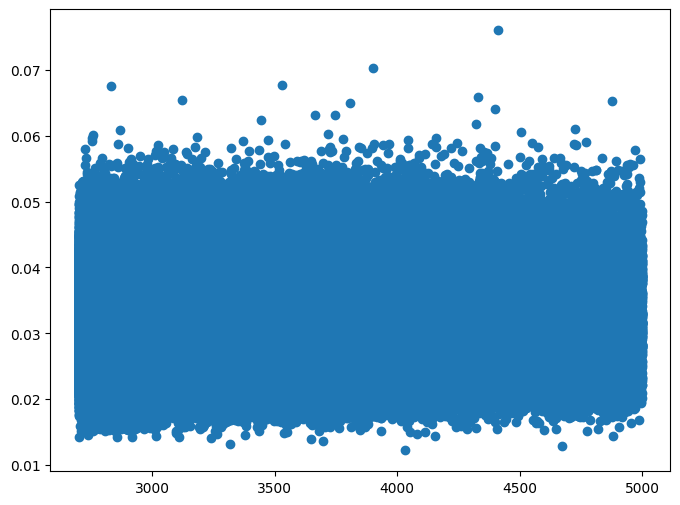

In [79]:
fig, axes = plt.subplots(figsize=(8,6))
axes.scatter(mjj_bkg.numpy(), loss_bkg_total.values)

In [74]:
mjj_bkg.shape

torch.Size([656455])

In [75]:
loss_bkg_total.shape

(656455,)

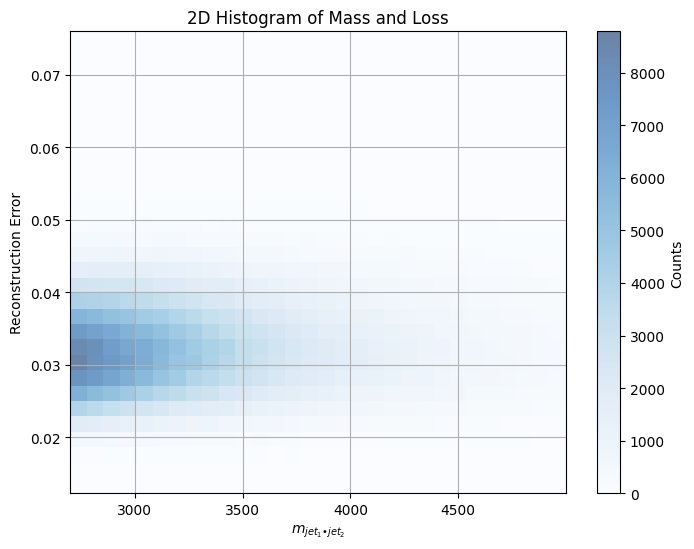

In [81]:
# Create a 2D histogram
plt.figure(figsize=(8, 6))
plt.hist2d(mjj_bkg.numpy(), loss_bkg_total.values, bins=30, cmap='Blues', alpha=0.6, label='Distribution 1')

# Add labels, title, and legend
plt.xlabel(r"$m_{jet_1•jet_2}$")
plt.ylabel('Reconstruction Error')
plt.title('2D Histogram of Mass and Loss')
plt.colorbar(label='Counts')
# plt.legend()

# Show plot
plt.grid(True)
plt.show()

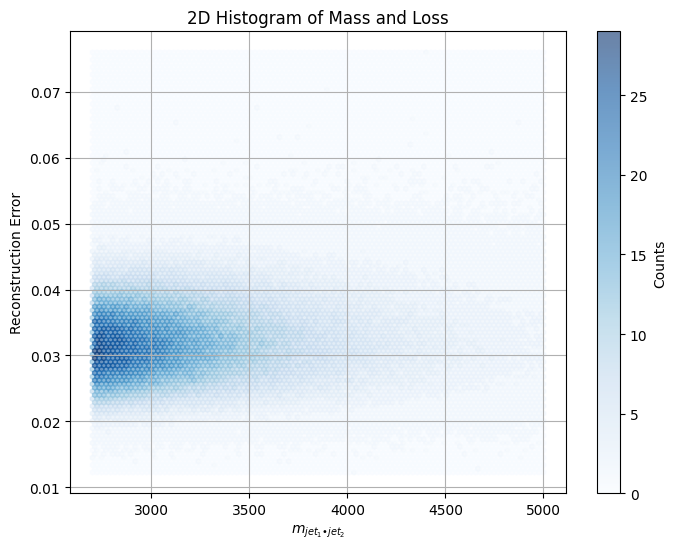

In [94]:
# Create a 2D histogram
plt.figure(figsize=(8, 6))
plt.hexbin(mjj_bkg.numpy(), loss_bkg_total.values, bins=30, cmap='Blues', alpha=0.6, label='Distribution 1')

# Add labels, title, and legend
plt.xlabel(r"$m_{jet_1•jet_2}$")
plt.ylabel('Reconstruction Error')
plt.title('2D Histogram of Mass and Loss')
plt.colorbar(label='Counts')
# plt.legend()

# Show plot
plt.grid(True)
plt.show()

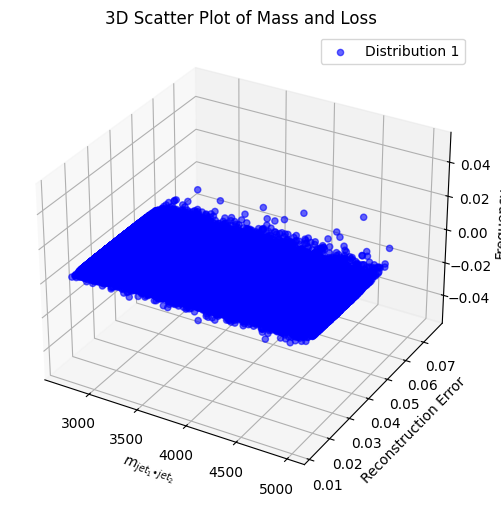

In [85]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mjj_bkg.numpy(), loss_bkg_total.values, np.zeros_like(mjj_bkg.numpy()), c='blue', label='Distribution 1', alpha=0.6)
ax.set_xlabel(r"$m_{jet_1•jet_2}$")
ax.set_ylabel('Reconstruction Error')
ax.set_zlabel('Frequency')
ax.set_title('3D Scatter Plot of Mass and Loss')
ax.legend()
plt.show()

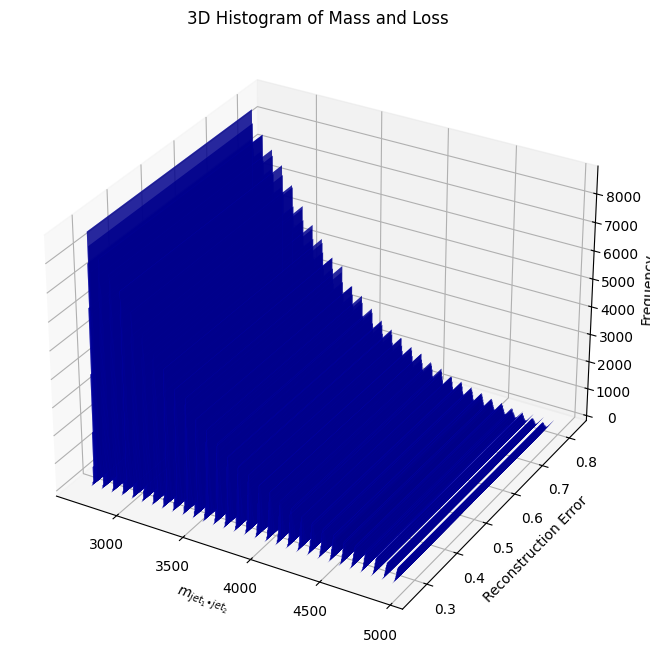

In [91]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Compute 3D histogram for distribution 1
hist1, xedges, yedges = np.histogram2d(mjj_bkg.numpy(), loss_bkg_total.values, bins=30)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

# Construct arrays with the dimensions for the bars
dx = dy = 0.5 * np.ones_like(zpos)
dz1 = hist1.ravel()

# Plot 3D histogram for distribution 1
ax.bar3d(xpos, ypos, zpos, dx, dy, dz1, zsort='average', color='blue', alpha=0.6, label='Distribution 1')

# Set labels and title
ax.set_xlabel(r"$m_{jet_1•jet_2}$")
ax.set_ylabel('Reconstruction Error')
ax.set_zlabel('Frequency')
ax.set_title('3D Histogram of Mass and Loss')

# Add legend
# ax.legend()

# Show plot
plt.show()

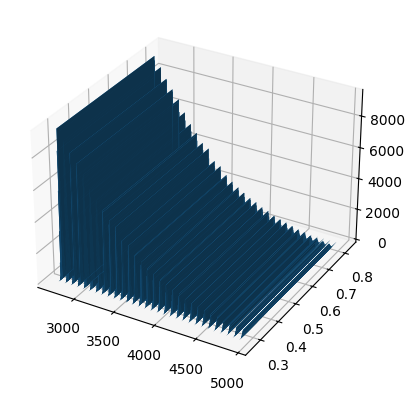

In [93]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(mjj_bkg.numpy(), loss_bkg_total.values, bins=30, range=[[2700, 5000], [0.01, 0.08]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()